<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v1/blob/main/Sector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-09-04 21:27:16


In [5]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [6]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

from google.colab import data_table

In [7]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [8]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [9]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [10]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [11]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
13,6491.34,7754.89,6032.0,7.62,TEXTILES,5285.65,54.0,19.47
7,6210.90,6923.76,5836.0,6.42,METAL,4300.90,48.0,11.48
14,4424.10,4913.51,4330.0,2.17,FOOTWEAR,3913.12,40.0,11.06
10,41843.00,45426.51,41575.0,0.64,CEMENT,37813.05,52.0,8.56
6,3512.34,3798.10,3272.0,7.35,MEDIA,2013.11,52.0,8.14
9,22296.45,23500.55,20724.0,7.59,CHEMICAL,17167.38,51.0,5.40
12,4878.70,5081.47,4633.0,5.30,JEWELLERY,4150.52,66.0,4.16
1,6685.25,6900.68,6257.0,6.84,BANKS,5546.85,57.0,3.22
8,29727.53,30329.07,26563.0,11.91,INFRA,20534.03,59.0,2.02
15,1969.02,1997.52,1505.0,30.83,SUGAR,1277.30,67.0,1.45


<Axes: xlabel='Date'>

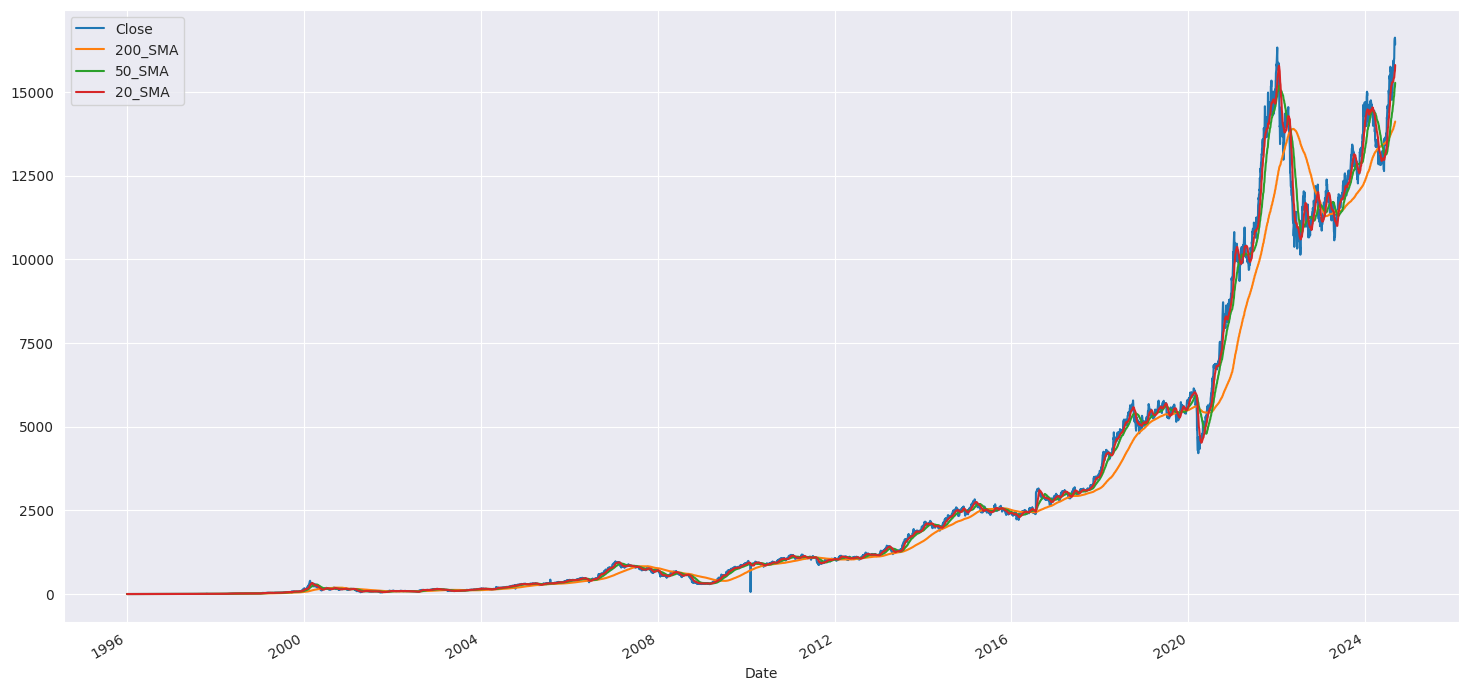

In [12]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [13]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
Date,,,,,,,,,,,,,,,,
2023-09-04 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-09-05 00:00:00+05:30,99.808673,99.949473,100.810938,100.637029,100.362463,100.362121,102.195302,100.706134,100.333006,100.317828,99.888699,99.920846,100.400044,103.098395,100.287373,99.830280
2023-09-06 00:00:00+05:30,99.469593,99.776580,101.186178,100.426386,101.398852,101.520624,102.672557,100.318234,101.027892,99.885808,99.902809,98.948111,101.094428,103.247165,101.289679,104.787468
2023-09-07 00:00:00+05:30,100.179733,100.864928,101.203395,101.450407,100.524885,101.301859,103.242727,100.605371,101.405349,99.871231,99.969878,100.565647,101.220752,102.838907,101.996442,104.085365
2023-09-08 00:00:00+05:30,100.903756,101.342796,102.499805,101.308526,100.487252,100.889873,103.210700,100.610340,101.430981,100.698700,100.447597,101.962618,102.071642,101.744997,102.569956,103.681590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-28 00:00:00+05:30,163.324615,113.764426,108.128239,127.297553,152.405207,148.220240,98.803554,130.211002,139.848650,115.913596,104.754415,202.665327,110.508118,112.294567,100.492858,149.428626
2024-08-29 00:00:00+05:30,164.874389,113.678666,110.558865,127.769871,153.986017,147.620996,98.340629,129.510625,140.455100,115.086324,105.046944,203.273903,110.536020,110.326926,100.150706,148.369093
2024-08-30 00:00:00+05:30,165.870406,113.852761,112.144047,128.284349,154.019858,149.870373,98.294696,129.846800,141.374264,115.601036,107.130424,202.298988,111.398720,111.449511,99.825383,154.259070


In [14]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

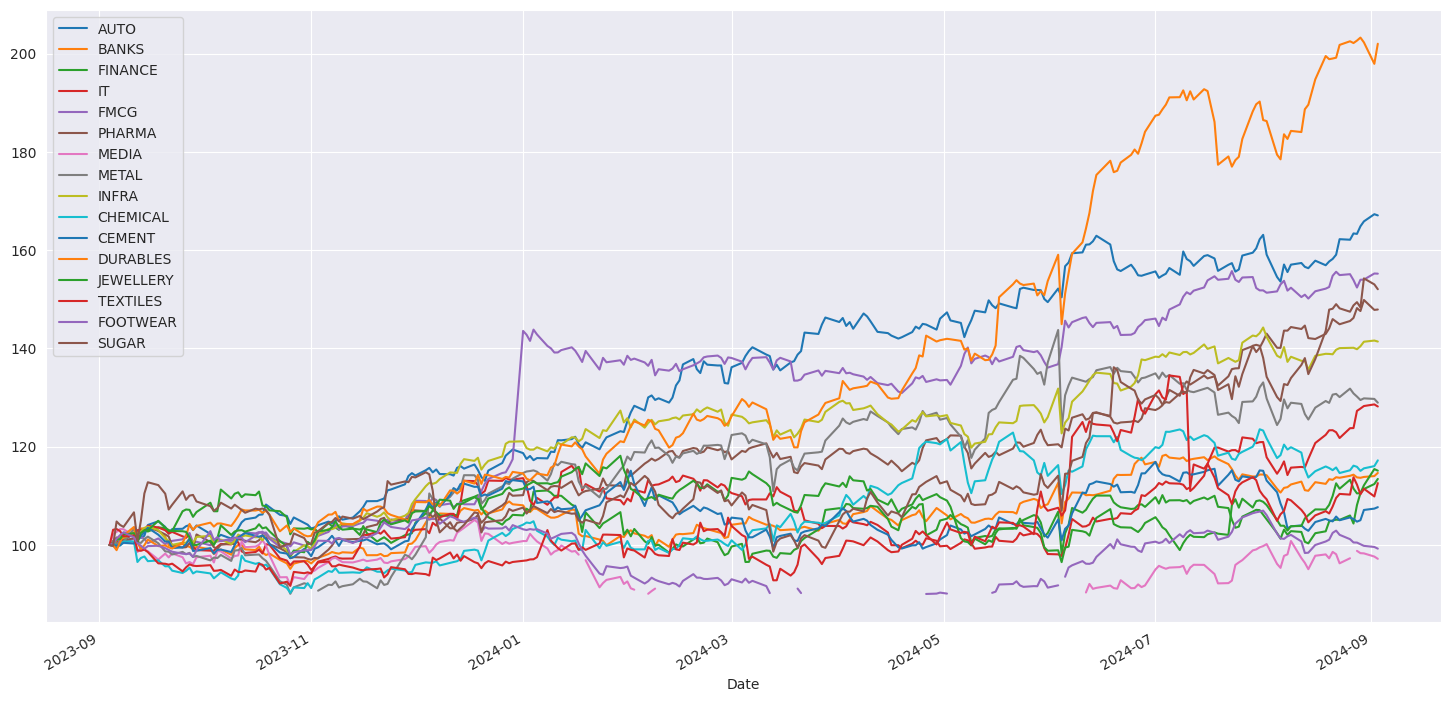

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [16]:
tmp_df

,Date,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
0,2023-09-04 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2023-09-05 00:00:00+05:30,99.808673,99.949473,100.810938,100.637029,100.362463,100.362121,102.195302,100.706134,100.333006,100.317828,99.888699,99.920846,100.400044,103.098395,100.287373,99.830280
2,2023-09-06 00:00:00+05:30,99.469593,99.776580,101.186178,100.426386,101.398852,101.520624,102.672557,100.318234,101.027892,99.885808,99.902809,98.948111,101.094428,103.247165,101.289679,104.787468
3,2023-09-07 00:00:00+05:30,100.179733,100.864928,101.203395,101.450407,100.524885,101.301859,103.242727,100.605371,101.405349,99.871231,99.969878,100.565647,101.220752,102.838907,101.996442,104.085365
4,2023-09-08 00:00:00+05:30,100.903756,101.342796,102.499805,101.308526,100.487252,100.889873,103.210700,100.610340,101.430981,100.698700,100.447597,101.962618,102.071642,101.744997,102.569956,103.681590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2024-08-28 00:00:00+05:30,163.324615,113.764426,108.128239,127.297553,152.405207,148.220240,98.803554,130.211002,139.848650,115.913596,104.754415,202.665327,110.508118,112.294567,100.492858,149.428626
240,2024-08-29 00:00:00+05:30,164.874389,113.678666,110.558865,127.769871,153.986017,147.620996,98.340629,129.510625,140.455100,115.086324,105.046944,203.273903,110.536020,110.326926,100.150706,148.369093
241,2024-08-30 00:00:00+05:30,165.870406,113.852761,112.144047,128.284349,154.019858,149.870373,98.294696,129.846800,141.374264,115.601036,107.130424,202.298988,111.398720,111.449511,99.825383,154.259070
242,2024-09-02 00:00:00+05:30,167.329255,114.030287,115.455052,128.618181,155.259043,147.851072,97.648033,129.734048,141.611440,116.056339,107.407382,197.936514,112.409081,109.886357,99.599899,153.041221
